In [93]:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)
# error_calculation_metrics = ['mean_squared_error', 'mean_absolute_error']
# ecm = error_calculation_metrics[1]
ecm = 'mean_absolute_error'
k_fold_value = 5

Before applying any machine learning algorithms, I wanted to see how each of the given predictors relate to each other.
To do it, I have found out pairplot() function from seaborn library which takes the name of columns (predictors) as
parameters and plots each one of them with another.

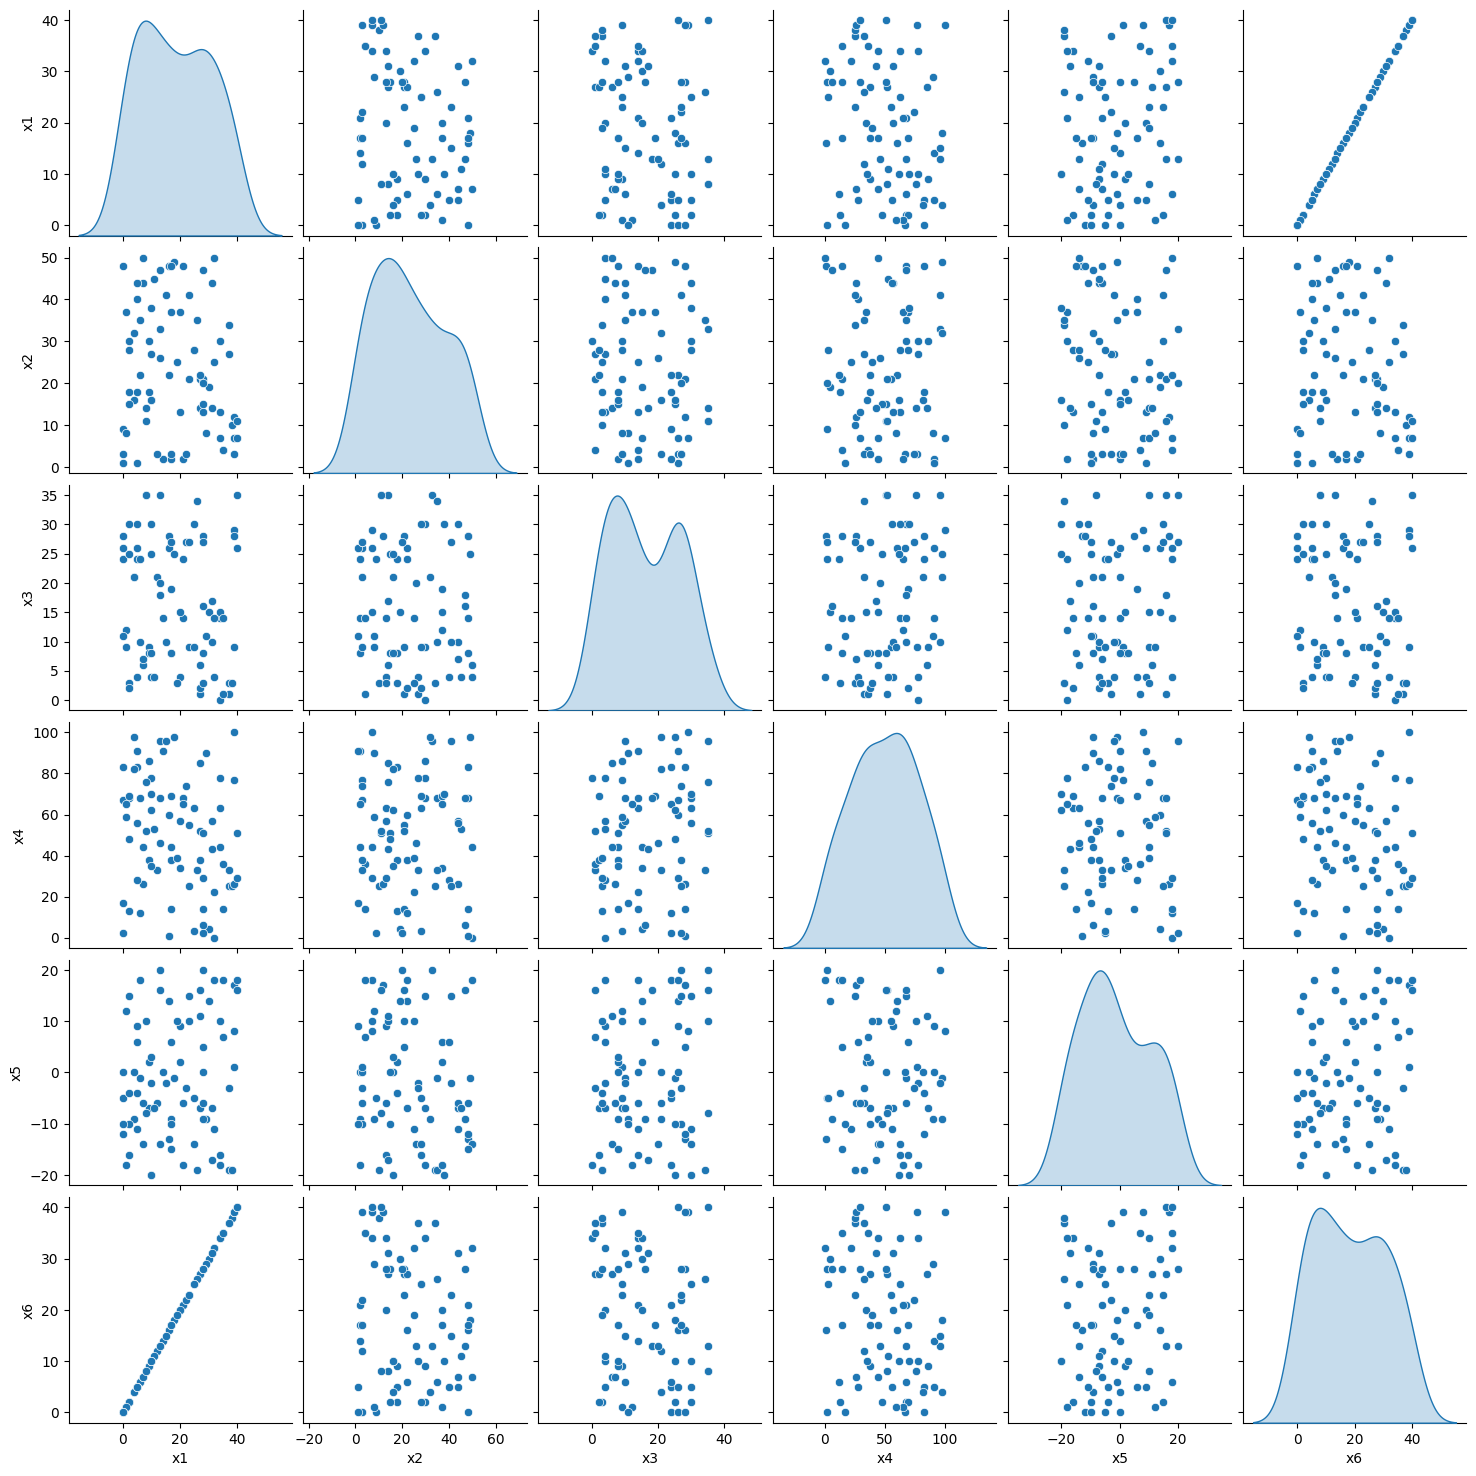

In [94]:
from sklearn.model_selection import KFold

raw_dataset = pd.read_csv('dataset_v1.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy()
predict_set = dataset.tail(20)
dataset = dataset.drop(predict_set.index)

predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']

def random_sample(train_fraction):
    train = dataset.sample(frac=train_fraction, random_state=0)
    test = dataset.drop(train.index)
    return train, test

def k_fold_sample(sample_source=dataset):
    kf = KFold(n_splits=k_fold_value, random_state=None, shuffle=False)

    features = np.array(sample_source[predictors])
    labels = np.array(sample_source['Y'])

    k_s = []
    for train_i, test_i in kf.split(dataset):
        k_s.append({'train_features': features[train_i],
                          'train_labels': labels[train_i],
                          'test_features': features[test_i],
                          'test_labels': labels[test_i]})
    return k_s

train_set, test_set = random_sample(train_fraction=0.8)

sns.pairplot(train_set[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']], diag_kind='kde')

From looking at the results, it is clear that x1 and x6 values are exactly the same. So, I have decided to drop x6
predictor since we do not need the same value twice.

Then, I wanted to see how each of those predictors relate to Y separately.

In [95]:
dataset = dataset.drop('x6', axis=1)
train_set = train_set.drop('x6', axis=1)
test_set = test_set.drop('x6', axis=1)
predictors.remove('x6')

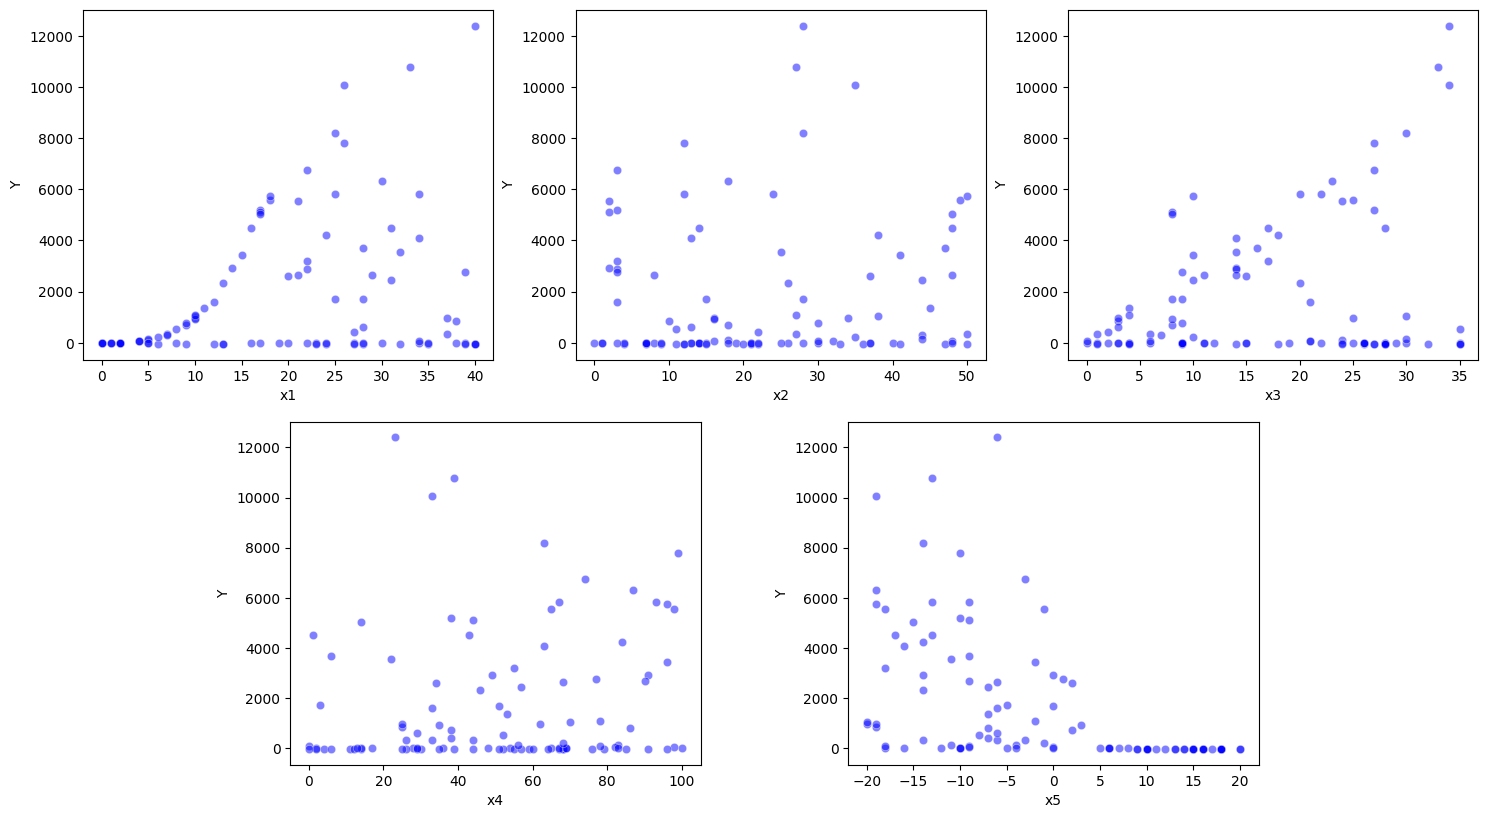

In [96]:
fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
axes_[1][2].set_visible(False)
axes_[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes_[1][1].set_position([0.55, 0.125, 0.228, 0.343])

for i_ in range(len(predictors)):
    sns.scatterplot(ax=axes_[i_ // 3, i_ % 3], x=dataset[predictors[i_]], y=dataset['Y'], alpha=0.5, color='b')

From here, I can see that when x1 has low values, their corresponding Y values are also tend to be low. Similarly,
when x5 has a value greater than 5, its corresponding Y value is very low.

Because of this, I assume that some kind of classification method must be applied.

In [97]:
k_samples = k_fold_sample()

train_features = train_set.copy()
test_features = test_set.copy()

train_labels = train_features.pop('Y')
test_labels = test_features.pop('Y')

table_heuristics = dataset.describe().transpose()[['min', 'max', 'mean', 'std']]

display(table_heuristics)

,min,max,mean,std
SampleNo,1.0,100.0,50.50,29.011492
x1,0.0,40.0,19.29,12.315954
x2,0.0,50.0,22.53,15.019486
x3,0.0,35.0,16.68,10.375651
x4,0.0,100.0,50.60,28.242814
x5,-20.0,20.0,-1.44,12.270783
Y,-42.0,12402.0,1746.82,2696.083648


# I. Linear Regression

In [98]:
from sklearn.linear_model import LinearRegression

all_test_results = {}

def calculate_mae(y_act, y_pred):
    test_error = 0
    for actual, predicted in zip(y_act, y_pred):
        test_error += abs(actual - predicted)
    return test_error/len(y_pred)

def calculate_rmse(y_act, y_pred):
    return np.sqrt(((y_act - y_pred) ** 2).sum()/len(y_pred))

def regression(model, x_train=train_features, y_train=train_labels, x_test=test_features, y_test=test_labels):
    x_regressor = LinearRegression().fit(x_train, y_train)
    y_predicted = x_regressor.predict(x_test)

    y_comparison = {'actual': list(y_test), 'predicted': y_predicted}
    mae_error = calculate_mae(y_act=y_comparison['actual'], y_pred=y_comparison['predicted'])

    return {'model': model,
            'comparison': pd.DataFrame(y_comparison).transpose(),
            'error': mae_error}

def display_error_table(result_dic=all_test_results):
    all_test_results = dict(sorted(result_dic.items(), key=lambda item: item[1]))
    display(pd.DataFrame([[k, v] for k,v in all_test_results.items()], columns=['model', ecm]))

## I.I. Single Linear Regression

,model,mean_absolute_error
0,linear_reg_x5,2324.413289
1,linear_reg_x1,3093.256187
2,linear_reg_x3,3145.202970
3,linear_reg_x4,3230.920433
4,linear_reg_x2,3243.874689


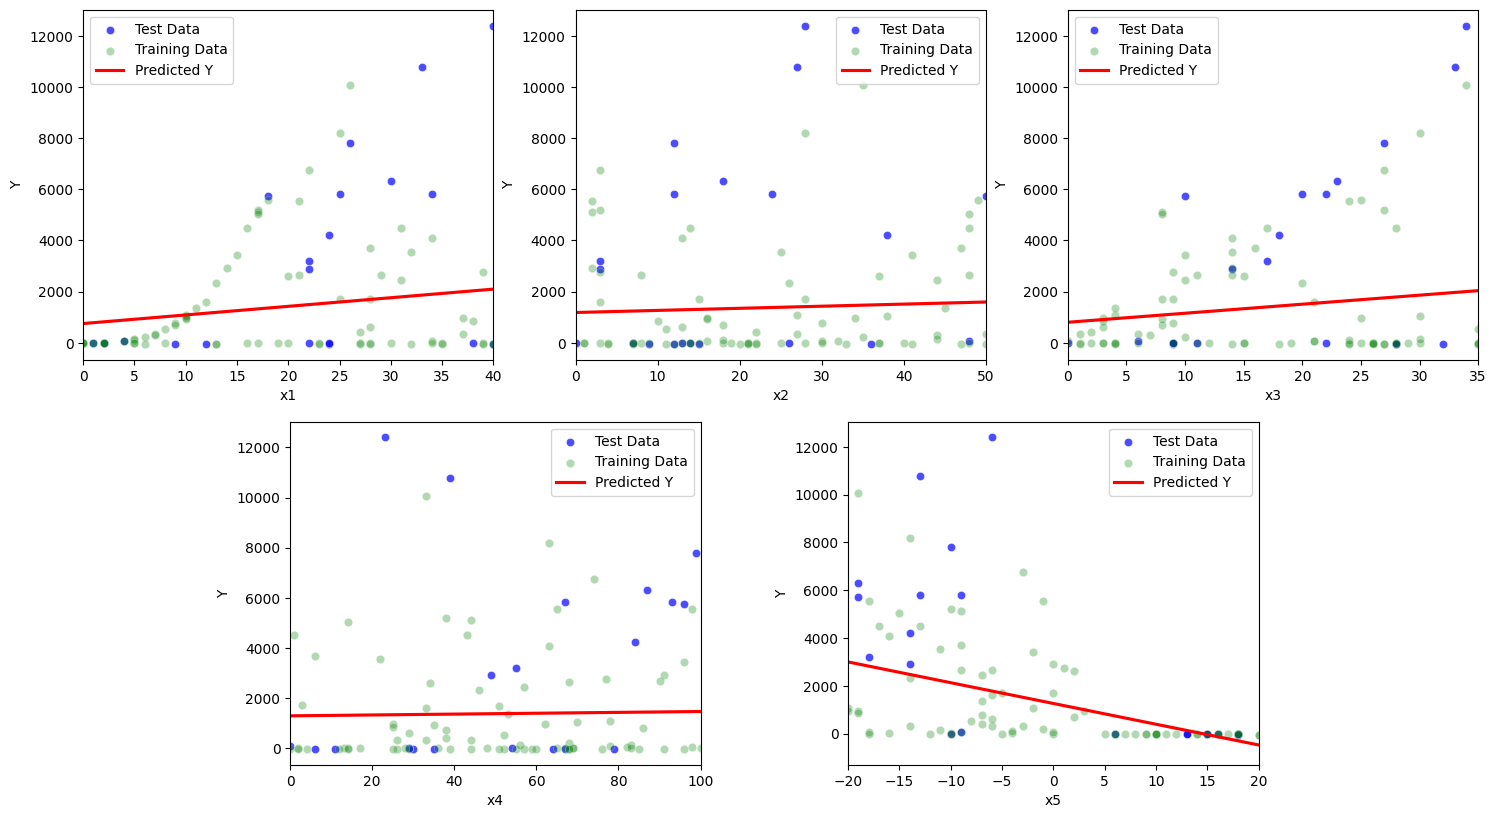

In [99]:
def single_linear_regression():

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes[1][2].set_visible(False)
    axes[1][0].set_position([0.24, 0.125, 0.228, 0.343])
    axes[1][1].set_position([0.55, 0.125, 0.228, 0.343])

    ax_i = 0
    for p in predictors:
        ax = axes[ax_i // 3, ax_i % 3]

        reg_result = regression(model=f'linear_reg_{p}',
                                x_train=np.array(train_features[p])[:, None], y_train=train_labels,
                                x_test=np.array(test_features[p])[:, None], y_test=test_labels)

        all_test_results[reg_result['model']] = reg_result['error']

        sns.scatterplot(ax=ax, x=test_features[p], y=test_labels,
                        alpha=0.7, color='b', label='Test Data')
        sns.scatterplot(ax=ax, x=train_features[p], y=train_labels,
                        alpha=0.3, color='g', label='Training Data')
        sns.regplot(ax=ax, x=test_features[p], y=reg_result['comparison'].loc['predicted'],
                    color='r', scatter=False, label='Predicted Y', truncate=False)

        ax.set_xlim(table_heuristics['min'][p], table_heuristics['max'][p])
        ax.set_xlabel(p)
        ax.set_ylabel('Y')
        ax.legend()
        ax_i += 1

single_linear_regression()
display_error_table()

## I.II. Multiple Linear Regression

In [100]:
display_error_table()

,model,mean_absolute_error
0,linear_reg_x5,2324.413289
1,linear_reg_x1,3093.256187
2,linear_reg_x3,3145.202970
3,linear_reg_x4,3230.920433
4,linear_reg_x2,3243.874689


## I.III. Polynomial Regression

In [105]:
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(x_train=train_features, y_train=train_labels,
                          x_test=test_features, y_test=test_labels, arg=2):

    poly_features = PolynomialFeatures(degree=arg, include_bias=False)
    poly_train_features = poly_features.fit_transform(x_train)
    return regression(model=f'polynomial_reg_o={arg}',
                      x_train=poly_train_features, y_train=y_train,
                      x_test=poly_features.fit_transform(x_test), y_test=y_test)


poly_reg_args = [2, 3, 4]
poly_reg_results = [polynomial_regression(x_train=train_features[predictors], x_test=test_features[predictors],
                                          y_train=train_labels, y_test=test_labels, arg=n) for n in poly_reg_args]

for poly_reg_result in poly_reg_results:
    all_test_results[poly_reg_result['model']] = poly_reg_result['error']

display_error_table()

,model,mean_absolute_error
0,polynomial_reg_o=2,1432.145261
1,k_nearest_reg_k=3,1903.650000
2,polynomial_reg_o=3,1988.578656
3,k_nearest_reg_k=2,2036.300000
4,k_nearest_reg_k=4,2116.800000
5,k_nearest_reg_k=5,2122.250000
6,linear_reg_x5,2324.413289
7,linear_reg_x1,3093.256187
8,linear_reg_x3,3145.202970
9,linear_reg_x4,3230.920433


## I.IV. K-Nearest-Neighbors Regression

In [102]:
def k_nearest_regression(x_train=train_features, y_train=train_labels,
                         x_test=test_features, y_test=test_labels, arg=3):
    def euclidean_dist(p_x, p_y):
        distances = list(map(lambda pr: (p_x[pr] - p_y[pr]) ** 2, predictors))
        return sum(distances)

    predictions = []
    for i in range(len(x_test.index)):
        current_row = x_test.iloc[i]
        current_distances = [[y_train.iloc[n], euclidean_dist(current_row, x_train.iloc[n])]
                             for n in range(len(x_train.index))]
        current_distances.sort(key=lambda n: n[1])
        k_nearest_avg = sum([n[0] for n in current_distances[:arg]]) // arg
        predictions.append(k_nearest_avg)

    y_comparison = {'actual': list(y_test), 'predicted': predictions}
    mae_error = calculate_mae(y_act=y_comparison['actual'], y_pred=y_comparison['predicted'])

    return {'model': f'k_nearest_reg_k={arg}',
            'comparison': pd.DataFrame(y_comparison).transpose(),
            'error': mae_error}


knn_args = [2, 3, 4, 5]
k_nearest_results = [k_nearest_regression(arg=k) for k in knn_args]

for knn_result in k_nearest_results:
    all_test_results[knn_result['model']] = knn_result['error']

display_error_table()

,model,mean_absolute_error
0,polynomial_reg_o=2,1432.145261
1,k_nearest_reg_k=3,1903.650000
2,polynomial_reg_o=3,1988.578656
3,k_nearest_reg_k=2,2036.300000
4,k_nearest_reg_k=4,2116.800000
5,k_nearest_reg_k=5,2122.250000
6,linear_reg_x5,2324.413289
7,linear_reg_x1,3093.256187
8,linear_reg_x3,3145.202970
9,linear_reg_x4,3230.920433


# TESTING

In [103]:
from sklearn.preprocessing import StandardScaler, normalize
# https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
# https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization

scaled_data = StandardScaler().fit_transform(dataset[predictors])
x_normalized = normalize(scaled_data, norm='l1', axis=0)
dataset_normalized = pd.DataFrame(x_normalized, columns=predictors)

dataset_normalized['Y'] = dataset['Y']
k_samples_norm = k_fold_sample(dataset_normalized)

In [111]:
def k_fold_cv(reg_func, arg):
    k_fold_cv_mae = 0
    for i in range(len(k_samples_norm)):
        ki_result = reg_func(x_train=k_samples_norm[i]['train_features'], y_train=k_samples_norm[i]['train_labels'],
                             x_test=k_samples_norm[i]['test_features'], y_test=k_samples_norm[i]['test_labels'], arg=arg)
        k_fold_cv_mae += ki_result['error']
    return k_fold_cv_mae/len(k_samples)


print('Poly Order=2', k_fold_cv(polynomial_regression, arg=2))
print('Poly Order=3', k_fold_cv(polynomial_regression, arg=3))
print('Poly Order=4', k_fold_cv(polynomial_regression, arg=4))

Poly Order=2 1090.2359411130415
Poly Order=3 1847.5249611205577
Poly Order=4 2137.9743670245884
